<a href="https://colab.research.google.com/github/zichenghuang/spam-email-detection/blob/main/naive_bayes_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

#Import Data

The data consists of examples of spam and non-spam emails, of which there are 4600 labeled examples. The feature vector $x$ is a 54-dimentional vector extracted from the email and $y=1$ indicates a spam email.

In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# import data
X = pd.read_csv('/gdrive/MyDrive/Repository/spam_email_detection/data/X.csv', 
                sep=',', 
                header=None)

y = pd.read_csv('/gdrive/MyDrive/Repository/spam_email_detection/data/y.csv', 
                sep=',', 
                header=None)

# Naive Bayes Classifier

We implement a naive Bayes classifier which is derived with assuming each dimension of $x$ is i.i.d. Poisson distributed with a Gamma prior. The distribution $p(y_0=y|\pi)= \text{Bernoulli}(y|\pi)$.

In every experiment below, we randomly partition the data into 10 folds and run the algorithm 10 different times so that each fold is held out as a test set one time. The final result we show is the cumulative result across these 10 folds.

## Implementation



In [4]:
# pi hat estimator
def pi_hat(y_train):

    input = np.asarray(y_train)
    output = {}

    labels = np.unique(input)
    counts = np.unique(input, return_counts=True)[1]

    for i in labels:
        
        output[int(i)] = float(counts[i])/input.shape[0]
    
    return output

In [5]:
# lambda hat estimator
def lambda_hat(X_train, y_train):

    input_X = np.asarray(X_train)
    input_y = np.asarray(y_train)
    output = {}

    labels = np.unique(input_y)

    for i in labels:
        
        indices = np.nonzero(input_y==int(i))[0]
        X_yi = input_X[indices]
        output[int(i)] = (1 + np.sum(X_yi, axis=0, keepdims=True))/(1 + indices.shape[0])

    return output

In [6]:
# naive Bayes classifier for 1 fold
def naive_bayes_prediction(X_test, X_train, y_train):

    input_X_test = np.asarray(X_test)
    input_X_train = np.asarray(X_train)
    input_y_train = np.asarray(y_train)
    output = np.zeros((len(input_X_test), 1), dtype=int)

    pi_new = pi_hat(input_y_train)
    lambda_new = lambda_hat(input_X_train, input_y_train)

    prob_0 = np.log(pi_new[0]) + np.dot(X_test, np.log(lambda_new[0]).T) - np.sum(lambda_new[0])
    prob_1 = np.log(pi_new[1]) + np.dot(X_test, np.log(lambda_new[1]).T) - np.sum(lambda_new[1])

    indices_1 = np.nonzero(prob_0 < prob_1)
    output[indices_1] = 1

    return output

In [7]:
# naive Bayes classifier for n foldes
def naive_bayes_classifier(X, y, n_folds=10, shuffle_data=True):
    
    input_X = np.asarray(X)
    input_y = np.asarray(y)

    # creat 10 folds partition
    kf = KFold(n_splits=n_folds, shuffle=shuffle_data)

    prediction_list = []
    truth_list = []

    labels = np.unique(input_y)
    avg_lambda_hat = {}

    for i in labels:

        avg_lambda_hat[int(i)] = np.zeros((1, input_X.shape[1]))

    for train_index, test_index in kf.split(input_X):
        
        X_test = input_X[test_index]
        y_test = input_y[test_index]
        X_train = input_X[train_index]
        y_train = input_y[train_index]

        y_hat = naive_bayes_prediction(X_test, X_train, y_train)
        y_hat_list = y_hat.reshape(y_hat.shape[0],).tolist()
        y_truth_list = y_test.reshape(y_test.shape[0],).tolist()

        prediction_list += y_hat_list
        truth_list += y_truth_list

        for i in labels:

            avg_lambda_hat[int(i)] += lambda_hat(X_train, y_train)[int(i)]
    
    for i in labels:
        
        avg_lambda_hat[int(i)] /= n_folds

    prediction = np.asarray(prediction_list).reshape(len(prediction_list), 1)
    truth = np.asarray(truth_list).reshape(len(truth_list), 1)

    true_negative = np.nonzero((prediction == 0) & (truth == 0))[0].shape[0]
    true_positive = np.nonzero((prediction == 1) & (truth == 1))[0].shape[0]
    false_negative = np.nonzero((prediction == 0) & (truth == 1))[0].shape[0]
    false_positive = np.nonzero((prediction == 1) & (truth == 0))[0].shape[0]
    accuracy = np.nonzero(prediction == truth)[0].shape[0] / len(truth)

    return true_negative, true_positive, false_negative, false_positive, accuracy, avg_lambda_hat

## Train the classifier

In [8]:
# train naive Bayes classifier on input X and y using 10 folds
tn, tp, fn, fp, accuracy, avg_lambda_hat = naive_bayes_classifier(X, y)

## Plot the confusion matrix and prediction accuracy

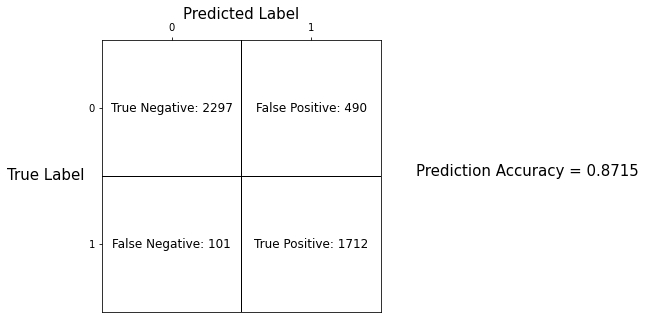

In [9]:
# 2 by 2 result table
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# plot the 2 by 2 table
ax.plot([-0.5, 1.5], [0.5, 0.5], '-k', lw=1)
ax.plot([0.5, 0.5], [-0.5, 1.5], '-k', lw=1)
ax.set_xlim(-0.5,1.5)
ax.set_ylim(1.5,-0.5)

# set xlabels
ax.set_xlabel('Predicted Label', fontsize=15)
ax.set_xticks([0, 1])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# set ylabels
ax.set_ylabel('True Label', fontsize=15, rotation=0)
ax.set_yticks([0, 1])
ax.yaxis.set_label_coords(-0.2, 0.475)

# fill in the 2 by 2 table
ax.text(0, 0, 'True Negative: %d'%(tn),va='center', ha='center', fontsize=12)
ax.text(0, 1, 'False Negative: %d'%fn,va='center', ha='center', fontsize=12)
ax.text(1, 0, 'False Positive: %d'%fp,va='center', ha='center', fontsize=12)
ax.text(1, 1, 'True Positive: %d'%(tp),va='center', ha='center', fontsize=12)
ax.text(1.75, 0.5, 'Prediction Accuracy = {:.4f}'.format(accuracy), fontsize=15)

plt.show()

## Show a stem plot of the 54 Poisson parameters for each class averaged across the 10 folds

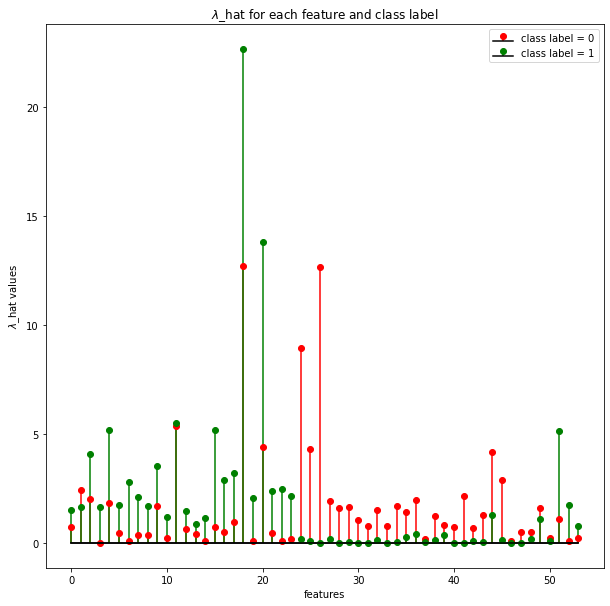

In [10]:
# stem plot
plt.figure(figsize=(10, 10))
ax = plt.subplot()
ax.stem(np.arange(54), 
         avg_lambda_hat[0].reshape(54,), 
         'r', 
         markerfmt='ro', 
         basefmt='black', 
         label='class label = 0', 
         use_line_collection=True)
ax.stem(np.arange(54), 
         avg_lambda_hat[1].reshape(54,), 
         'g', 
         markerfmt='go', 
         basefmt='black', 
         label='class label = 1', 
         use_line_collection=True)
ax.legend()
ax.set_title(r'$\lambda$_hat for each feature and class label')
ax.set_xlabel('features')
ax.set_ylabel(r'$\lambda$_hat values')
plt.show()

In [11]:
avg_lambda_hat[0][0, 15]

0.7396222043804813

In [12]:
avg_lambda_hat[1][0, 15]

5.213453537244169

For dimensions 16 ("Free"), the Poisson parameter for class labeled "0" is approximately 0.7396 and the Poisson parameter for class label "1" is approximately 5.2136. 

This suggests that there is a much higher chance (about $5.2136/0.7396 \approx 7$ times) to see the word "Free" in a spam email than in a non-spam email. 

In [13]:
avg_lambda_hat[0][0, 51]

1.0961918447390073

In [14]:
avg_lambda_hat[1][0, 51]

5.129301885796816

For dimensions 52 ("!"), the Poisson parameter for class labeled "0" is approximately 1.0962 and the Poisson parameter for class label "1" is approximately 5.1292. 

This suggests that there is a much higher chance (about $5.1292/1.0961 \approx 5$ times) to see the word "!" in a spam email than in a non-spam email. 

Based on these observations, the words "Free" and "!" both have a much higher chance of appearing in a spam email.